Marklin Example 1: Compute and trace Taylor states in an elongated cylinder {#doc_marklin_ex1}
==========
In this example we compute the Taylor state in a R=1, L=10 cylinder with Marklin and then demonstrate tracing the magnetic field and the vector potential.

In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

### Load Marklin library

To load the Marklin python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.Marklin import Marklin

## Create Marklin solver object

In [3]:
taylor_solver = Marklin()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   Marklin_save_interp
Revision id:          d0670bd
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



## Load mesh

In [4]:
taylor_solver.setup_mesh(mesh_file='cyl10_mesh.h5')


**** Loading OFT mesh
  Mesh File = cyl10_mesh.h5

**** Generating grid level  1
  Generating domain linkage
  Generating boundary domain linkage
  Mesh statistics:
    Volume          =  3.125E+01
    Surface area    =  6.899E+01
    # of points     =    6867
    # of edges      =   43660
    # of faces      =   71594
    # of cells      =   34800
    # of boundary points =    1996
    # of boundary edges  =    5982
    # of boundary faces  =    3988
    # of boundary cells  =    3928
  Resolution statistics:
    hmin =  1.101E-01
    hrms =  2.077E-01
    hmax =  3.575E-01
  Surface grounded at vertex    1482



## Compute Taylor state (1 eigenmode) using 2nd order elements

In [5]:
taylor_solver.compute(1,2)


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 No Lagrange MG smoother settings found:
   Using default values, which may result in convergence failure.

**** Creating Nedelec H1(Curl) FE space
  Order  =    2
  Minlev =   -1

 No H(Curl) MG smoother settings found:
   Using default values, which may result in convergence failure.

Starting calculation of Taylor states

Starting CG eigensolver
     0  2.374621E+04  3.277373E+06
     1  5.228970E+01  1.407083E+01
     2  3.274646E+01  5.494462E+00
     3  2.455146E+01  3.126270E+00
     4  1.999313E+01  2.597422E+00
     5  1.721738E+01  2.112855E+00
     6  1.544951E+01  1.777189E+00
     7  1.421654E+01  1.506215E+00
     8  1.321035E+01  1.358128E+00
     9  1.240993E+01  1.218321E+00
    10  1.174138E+01  1.205306E+00
    20  7.889045E+00  6.456642E-01
    30  6.248374E+00  5.559782E-01
    40  5.227609E+00  4.013179E-01
    50  4.547448E+00  3.128163E-01
    60  4.132212E+00  1.989343E-01
    70  3.892467E+00  1

## Save B-field and two different forms of vector potential
Here we save fields by building interpolators for each field and passing them to \ref OpenFUSIONToolkit.Marklin.Marklin.save_field "save_field()". The vector potential is saved twice with two different gauges:
  1) $A \times \hat{n} = 0$
  2) $A \cdot \hat{n} = 0$

In [6]:
taylor_solver.setup_io()
# Save vector potential with default gauge (A_t = 0 @ wall)
ainterp_obj = taylor_solver.get_ainterp(imode=1)
taylor_solver.save_field(ainterp_obj,'A')
# Save vector potential with B-field gauge (A_n = 0 @ wall)
ainterp_obj_zero_norm = taylor_solver.get_ainterp(imode=1,bn_gauge=True)
taylor_solver.save_field(ainterp_obj_zero_norm,'A_znorm')
# Save magnetic field
binterp_obj = taylor_solver.get_binterp(imode=1)
taylor_solver.save_field(binterp_obj,'B')
taylor_solver.build_XDMF()


**** Creating Nedelec H0 FE space
  Order  =    3
  Minlev =    3


**** Creating Nedelec H1 FE space
  Order  =    2
  Minlev =    2

Starting CG solver
     0  0.000000E+00  0.000000E+00  1.360151E-02
     1 -5.435359E-04  2.547582E-01  3.605801E-03  1.415382E-02
     2 -5.890805E-04  2.135218E-01  3.168248E-03  1.483805E-02
     3 -6.154921E-04  1.525890E-01  2.738276E-03  1.794543E-02
     4 -6.281661E-04  1.225852E-01  1.520596E-03  1.240440E-02
     5 -6.319239E-04  1.165810E-01  9.861016E-04  8.458513E-03
     6 -6.331919E-04  1.153084E-01  6.079816E-04  5.272657E-03
     7 -6.336948E-04  1.149253E-01  4.600453E-04  4.002993E-03
     8 -6.339902E-04  1.149019E-01  4.078759E-04  3.549774E-03
     9 -6.342542E-04  1.151905E-01  3.521862E-04  3.057424E-03
    10 -6.344553E-04  1.152140E-01  2.909353E-04  2.525172E-03
    20 -6.349429E-04  1.136201E-01  5.440901E-05  4.788677E-04
    30 -6.349562E-04  1.138686E-01  9.754762E-06  8.566687E-05
    40 -6.349567E-04  1.138714E-01  1.46

## Trace magnetic field and vector potential
**Note:** Vector potential with $A \cdot \hat{n} = 0$ is used for tracing, as otherwise most (all?) traces will quickly intersect the boundary.

In [7]:
import time
from scipy.integrate import odeint
def tracer_eval(y, t, interp_obj, fac):
    b = interp_obj.eval(y)
    if interp_obj.cell.value <= 0:
        return [0.0,0.0,0.0]
    else:
        return b*fac

In [8]:
t = np.linspace(0, 800, 1000)
# Trace magnetic field
t0 = time.perf_counter()
sol, infodict = odeint(tracer_eval, np.array([0.01,0.0,4.9]), t, args=(binterp_obj,1.0), atol=1.E-9, full_output=True)
t1 = time.perf_counter()
print("Time = {0:.3F} [s]".format(t1-t0))
print("Time/step = {0:.2E} [s]".format((t1-t0)/np.sum(infodict['nfe'])))
print()
# Trace vector potential
t0 = time.perf_counter()
sol2, infodict = odeint(tracer_eval, np.array([0.01,0.0,4.9]), t, args=(ainterp_obj_zero_norm,3.161823), atol=1.E-9, full_output=True)
t1 = time.perf_counter()
print("Time = {0:.3F} [s]".format(t1-t0))
print("Time/step = {0:.2E} [s]".format((t1-t0)/np.sum(infodict['nfe'])))

Time = 0.456 [s]
Time/step = 7.87E-09 [s]

Time = 0.258 [s]
Time/step = 7.85E-09 [s]


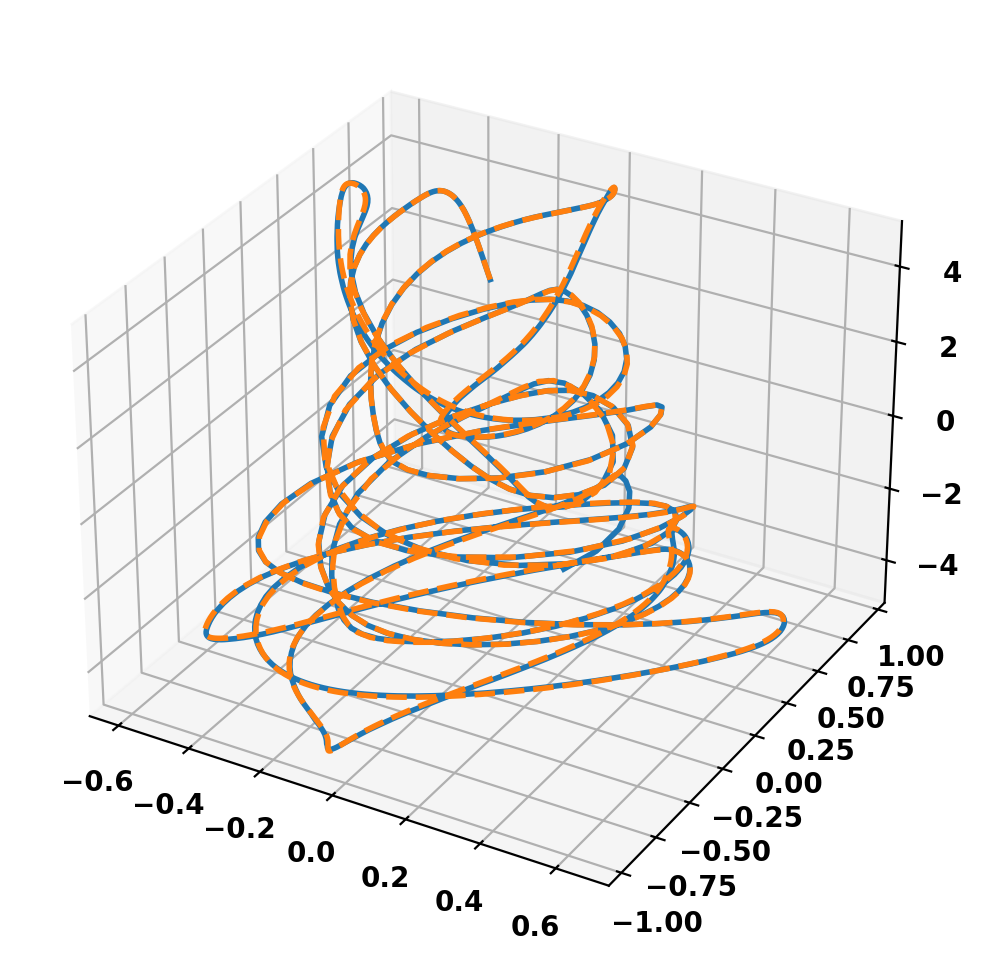

In [9]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(sol[:,0],sol[:,1],sol[:,2])
ax.plot(sol2[:,0],sol2[:,1],sol2[:,2],linestyle='--')
ax.set_aspect('auto')